In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1
!pip install scikit-multilearn
!pip install gspread

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.1 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.2 which is incompatible.
mlxtend 0.20.0 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.1 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.24.1 which is incompatible.
gplearn 0.4.2 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import re
from sklearn.metrics import *
import time

In [3]:
def cm_labels(cm):
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return labels

In [4]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None, multilabel=False):
    target_names = list(y_test.columns)    
    if multilabel:
        if len(pred.shape) == 1:
            num = np.unique(y_pred, axis=0)
            num = num.shape[0]
            pred_converted = np.eye(num)[pred]
            pred = pred_converted

        total_accuracy = accuracy_score(y_test, pred)
        print(f'total accuracy: {total_accuracy}')
        
        accuracy_dict = {}
        for i, y in enumerate(y_test.columns):
            accuracy = accuracy_score(y_test[y], pred[:, i])
            accuracy_dict[y] = accuracy
            print(f'{y} accuracy: {accuracy}')
        
        fig1, axes1 = plt.subplots(2, 2, figsize=(17, 17))
        fig2, axes2 = plt.subplots(2, 2, figsize=(17, 17))

        axes_list1 = [ax for sublist in axes1 for ax in sublist]
        axes_list2 = [ax for sublist in axes2 for ax in sublist]
        flattend_axes = axes_list1 + axes_list2

        cms = multilabel_confusion_matrix(y_test, pred)
        for i, ax in enumerate(flattend_axes):
            labels = cm_labels(cms[i])
            sns.heatmap(cms[i], annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')
    else:
        accuracy = accuracy_score(y_test, pred)
        print(f'accuracy: {accuracy}')
        
        cm = confusion_matrix(y_test, pred)
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=title)
    
    print(classification_report(y_test, pred, target_names=target_names))
    plt.show()
    
    report_dict = classification_report(y_test, pred, target_names=target_names, output_dict=True)
    
    for k, v in accuracy_dict.items():
        report_dict[k]['accuracy'] = v
    
    report_dict['total accuracy'] = total_accuracy
    return report_dict

# DATA A

In [5]:
data_a = pd.read_csv('../input/sleep-research/preprocessed_data_a.csv')
data_a.head()

,sex,age,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control,...,Lowest SaO2 (%),ODI,90%ODI,EtCO2 (>50mmHg),Total LMI =PLMI(/h),Total LM Arousal#,Total LM AI(/h),PLM Arousal#,PLM AI(/h),MAI(/h)
0,1,55,1,0,0,0,0,0,0,0,...,88.0,0.0,0.0,0.0,3.2,2.0,0.3,0.0,0.0,0.3
1,0,48,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,55,1,0,0,0,0,0,0,0,...,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,50,1,0,0,0,0,0,0,0,...,83.0,0.0,0.0,0.0,46.8,0.0,0.0,0.0,0.0,0.0
4,0,57,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.model_selection import train_test_split

target_a = data_a.iloc[:, 2:10]
features_a = data_a.drop(data_a.iloc[:, 2:10], axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features_a, target_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [7]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skmultilearn.ensemble import RakelD
from sklearn.model_selection import GridSearchCV

parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, True], 'labelset_size': 8} 0.8152478795353227


total accuracy: 0.7574385510996119
OSA accuracy: 0.9139715394566623
insomnia accuracy: 0.9243208279430789
PLMD, RLS accuracy: 0.9062095730918499
parasomnia accuracy: 0.9611901681759379
circadian rhythm sleep-wake disorder accuracy: 0.9780077619663649
Narcolepsy, EDS, Hypersomnia accuracy: 0.9702457956015524
Catathrenia accuracy: 0.9987063389391979
control accuracy: 0.9456662354463131


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.93      0.96      0.94      1147
                            insomnia       0.62      0.50      0.56       146
                           PLMD, RLS       0.60      0.45      0.52       172
                          parasomnia       0.40      0.07      0.12        58
circadian rhythm sleep-wake disorder       0.18      0.07      0.11        27
        Narcolepsy, EDS, Hypersomnia       0.54      0.15      0.23        47
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.65      0.70      0.68       125

                           micro avg       0.84      0.79      0.81      1724
                           macro avg       0.49      0.36      0.39      1724
                        weighted avg       0.81      0.79      0.79      1724
                         samples avg       0.85      0.82     

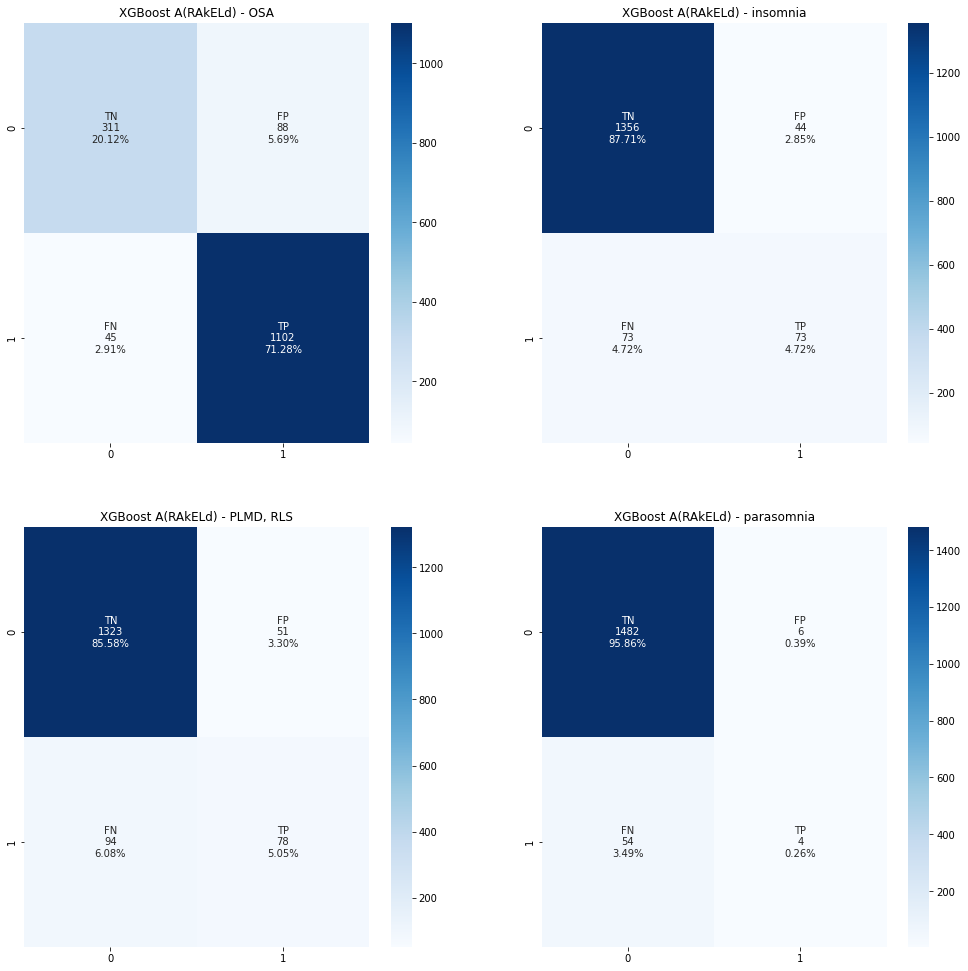

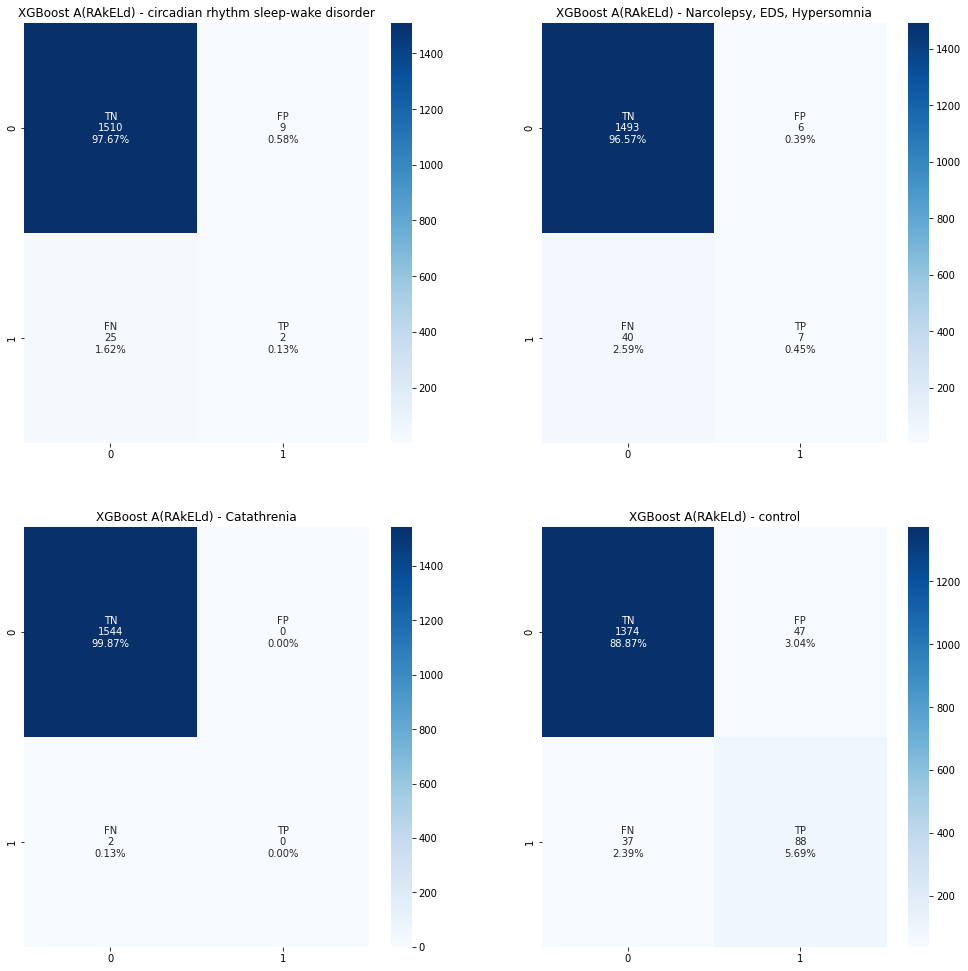

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [9]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [10]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+7, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+7, cell.col, score)

In [11]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, False], 'labelset_size': 11} 0.8219680268632746


total accuracy: 0.759379042690815
OSA accuracy: 0.9120310478654593
insomnia accuracy: 0.9204398447606728
PLMD, RLS accuracy: 0.906856403622251
parasomnia accuracy: 0.96248382923674
circadian rhythm sleep-wake disorder accuracy: 0.98124191461837
Narcolepsy, EDS, Hypersomnia accuracy: 0.9702457956015524
Catathrenia accuracy: 0.9987063389391979
control accuracy: 0.9424320827943079


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.92      0.97      0.94      1147
                            insomnia       0.62      0.40      0.49       146
                           PLMD, RLS       0.62      0.43      0.51       172
                          parasomnia       0.00      0.00      0.00        58
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        27
        Narcolepsy, EDS, Hypersomnia       0.67      0.04      0.08        47
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.62      0.76      0.68       125

                           micro avg       0.85      0.78      0.81      1724
                           macro avg       0.43      0.33      0.34      1724
                        weighted avg       0.79      0.78      0.77      1724
                         samples avg       0.85      0.81     

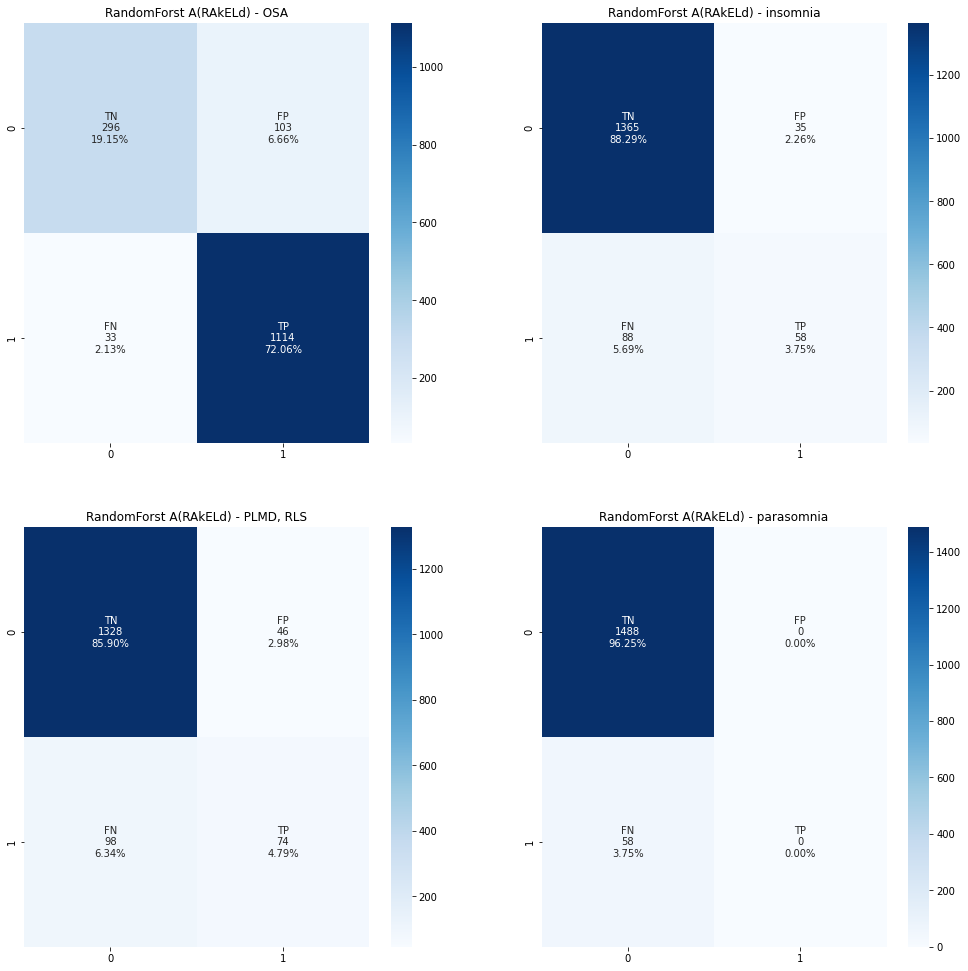

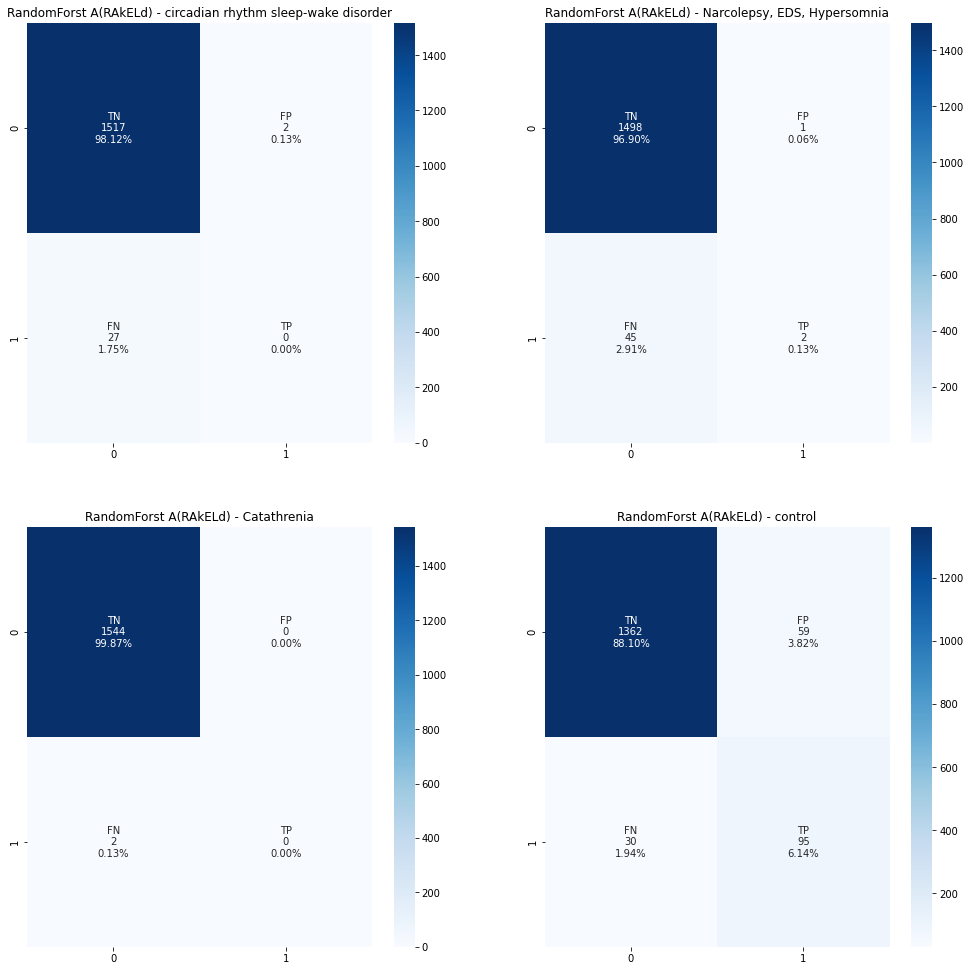

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [13]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [14]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+1, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+1, cell.col, score)

In [15]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, False], 'labelset_size': 7} 0.7950052662863816


total accuracy: 0.5588615782664942
OSA accuracy: 0.7076326002587322
insomnia accuracy: 0.8971539456662354
PLMD, RLS accuracy: 0.8609314359637775
parasomnia accuracy: 0.964424320827943
circadian rhythm sleep-wake disorder accuracy: 0.98124191461837
Narcolepsy, EDS, Hypersomnia accuracy: 0.9683053040103493
Catathrenia accuracy: 0.9987063389391979
control accuracy: 0.8221216041397154


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.76      0.90      0.82      1147
                            insomnia       0.00      0.00      0.00       146
                           PLMD, RLS       0.32      0.22      0.26       172
                          parasomnia       0.71      0.09      0.15        58
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        27
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        47
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.05      0.06      0.05       125

                           micro avg       0.65      0.63      0.64      1724
                           macro avg       0.23      0.16      0.16      1724
                        weighted avg       0.56      0.63      0.58      1724
                         samples avg       0.65      0.64     

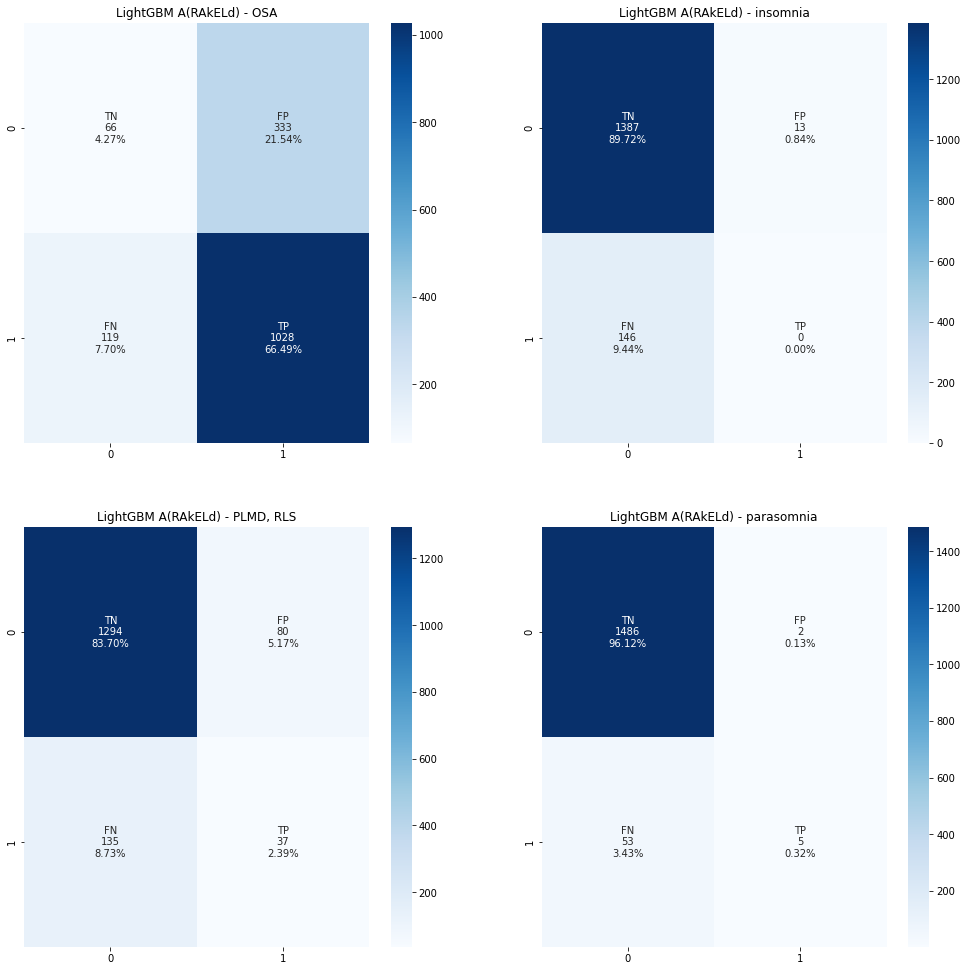

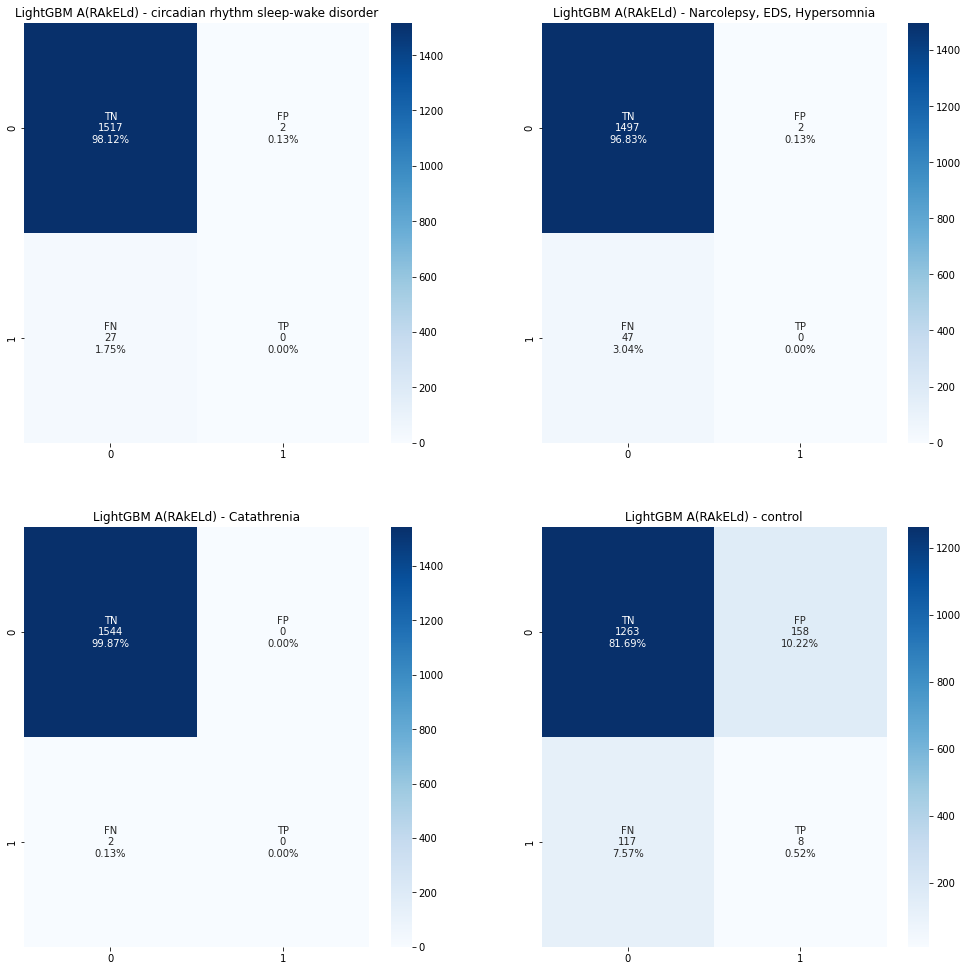

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [17]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [18]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+13, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+13, cell.col, score)

## MLSMOTE

In [19]:
X_a = features_a.to_numpy()
Y_a = target_a.to_numpy()

In [20]:
from sklearn.neighbors import NearestNeighbors


def IRLbl(Y):
    # imbalance ratio per label
    pos_nums_per_label = np.sum(Y, axis=0)
    max_pos_nums = np.max(pos_nums_per_label)
    return max_pos_nums / pos_nums_per_label


def MeanIR(Y):
    # average imbalance ratio
    IRLbl_VALUE = IRLbl(Y)
    return np.mean(IRLbl_VALUE)


def TailLabel(Y):
    n, m = Y.shape
    irlbl = IRLbl(Y)
    mean_ir = MeanIR(Y)
    return np.where(irlbl>=mean_ir)[0]


def MinBag(X, Y, label_index):
    pos = np.where(Y[:,label_index]==1)
    sample_index = list(set(pos[0]))
    X_minor, Y_minor = X[sample_index,:], Y[sample_index,:]
    return X_minor, Y_minor


def NN_index(X, k=5):
    # n_neighbors including the sample itself, 
    # so we take the number of n_neighbors as k+1 (as the following shows),
    # then delete itself from the neighbors.
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', 
                           algorithm='auto').fit(X)
    euclidean, index = nn.kneighbors(X)
    return index[:,1:]


def MLSMOTE(X_minor, Y_minor, k=5):
    n, p = X_minor.shape
    m = Y_minor.shape[1]
    X_synth = np.zeros((n,p))
    Y_synth = np.zeros((n,m))
    
    nn_index = NN_index(X_minor, k=5)
    for i in range(n):
        # generate sample feature, that is, X
        sample_X = X_minor[i,:]
        rand_ind = np.random.randint(0, k)
        ref_index = nn_index[i,rand_ind]
        refNeigh = X_minor[ref_index,:]
        diff = sample_X - refNeigh
        offset = diff*np.random.uniform(0, 1, (1,p))
        X_synth[i,:] = sample_X + offset
        
        # generate sample labels Y with the voting method
        sample_nn_index = nn_index[i,:]
        nn_label = Y_minor[sample_nn_index,:]
        Y_synth[i,:] = (np.sum(nn_label, axis=0)>=((k+1)/2))
    X_new = np.r_[X_minor, X_synth]
    Y_new = np.r_[Y_minor, Y_synth]
    return X_new, Y_new

In [21]:
label_index_a = TailLabel(Y_a)

X_minor_a, Y_minor_a = MinBag(X_a, Y_a, label_index_a)
X_new_a, Y_new_a = MLSMOTE(X_minor_a, Y_minor_a, k=5)

print(X_new_a.shape, Y_new_a.shape)

(14, 77) (14, 8)


In [22]:
mlsmote_data_a = pd.DataFrame(X_new_a, columns=data_a.columns[:2].tolist()+data_a.columns[10:].tolist())
mlsmote_label_a = pd.DataFrame(Y_new_a, columns=data_a.columns[2:10].tolist())

X_df_a = pd.concat([features_a, mlsmote_data_a], axis=0)
Y_df_a = pd.concat([target_a, mlsmote_label_a], axis=0)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_df_a, Y_df_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [23]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, False], 'labelset_size': 8} 0.8126420505923496


total accuracy: 0.7645161290322581
OSA accuracy: 0.9148387096774193
insomnia accuracy: 0.9219354838709677
PLMD, RLS accuracy: 0.912258064516129
parasomnia accuracy: 0.9619354838709677
circadian rhythm sleep-wake disorder accuracy: 0.9767741935483871
Narcolepsy, EDS, Hypersomnia accuracy: 0.9716129032258064
Catathrenia accuracy: 0.9980645161290322
control accuracy: 0.944516129032258
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.95      0.95      1190
                            insomnia       0.51      0.53      0.52       124
                           PLMD, RLS       0.67      0.43      0.53       175
                          parasomnia       0.45      0.09      0.14        58
circadian rhythm sleep-wake disorder       0.20      0.07      0.10        30
        Narcolepsy, EDS, Hypersomnia       0.40      0.10      0.15        42
                         Catathrenia       1.00      0.50      0.67 

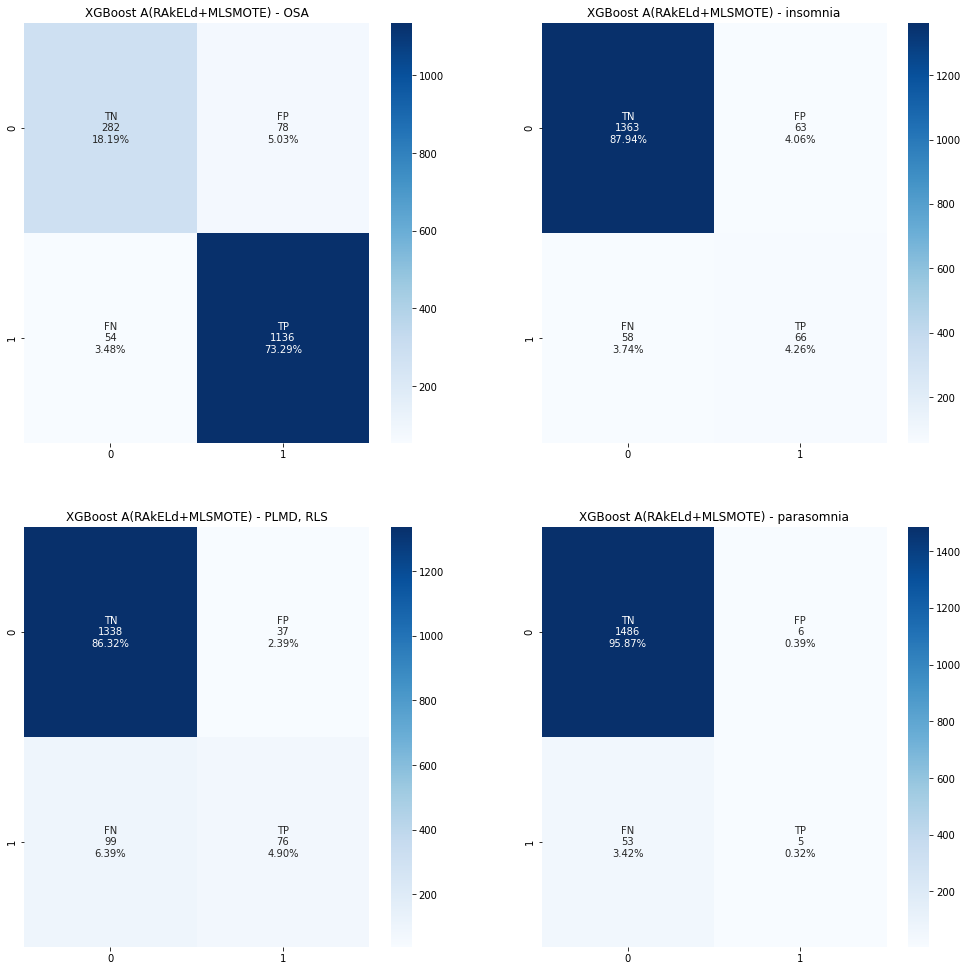

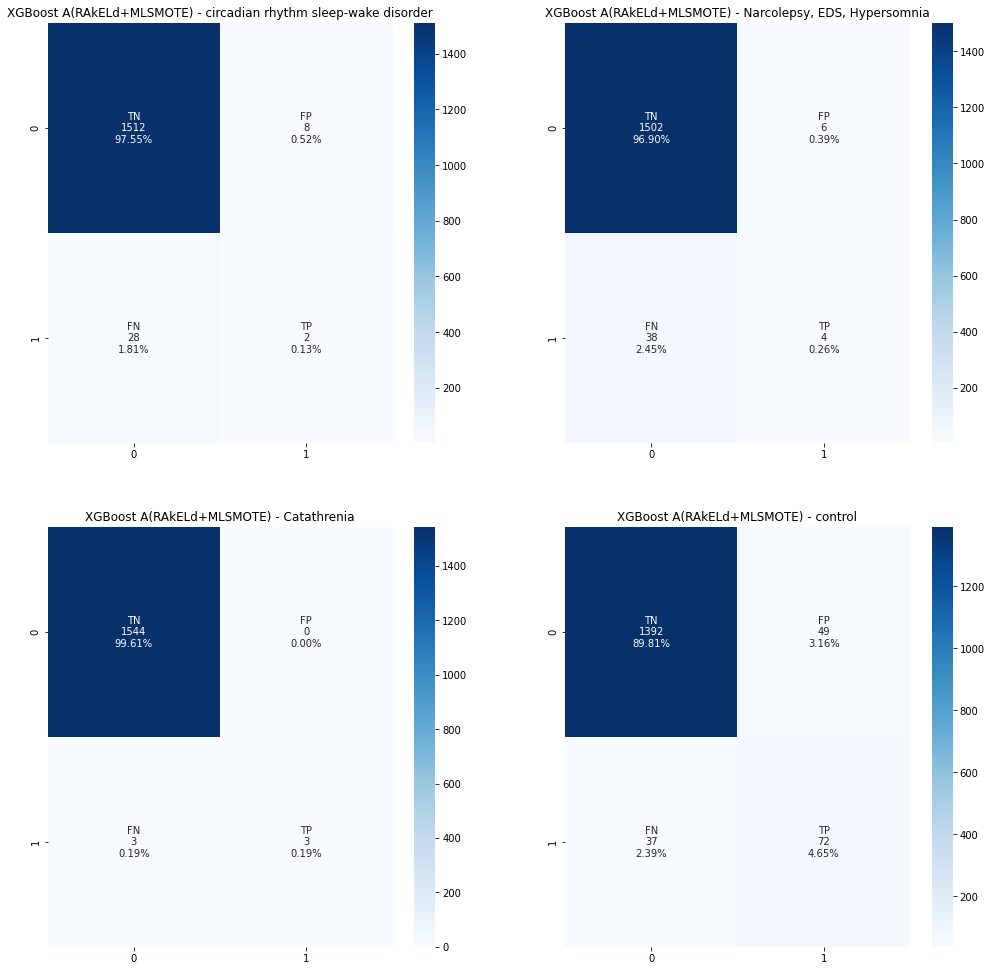

In [24]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [25]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [26]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+8, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+8, cell.col, score)

In [27]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, False], 'labelset_size': 6} 0.8048063623789764


total accuracy: 0.5567741935483871
OSA accuracy: 0.9116129032258065
insomnia accuracy: 0.8283870967741935
PLMD, RLS accuracy: 0.7941935483870968
parasomnia accuracy: 0.9632258064516129
circadian rhythm sleep-wake disorder accuracy: 0.9554838709677419
Narcolepsy, EDS, Hypersomnia accuracy: 0.9574193548387097
Catathrenia accuracy: 0.9896774193548387
control accuracy: 0.927741935483871


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.94      0.95      0.94      1190
                            insomnia       0.21      0.43      0.28       124
                           PLMD, RLS       0.23      0.34      0.27       175
                          parasomnia       0.67      0.03      0.07        58
circadian rhythm sleep-wake disorder       0.02      0.03      0.03        30
        Narcolepsy, EDS, Hypersomnia       0.12      0.10      0.11        42
                         Catathrenia       0.00      0.00      0.00         6
                             control       0.36      0.04      0.07       109

                           micro avg       0.69      0.72      0.71      1734
                           macro avg       0.32      0.24      0.22      1734
                        weighted avg       0.73      0.72      0.70      1734
                         samples avg       0.71      0.75     

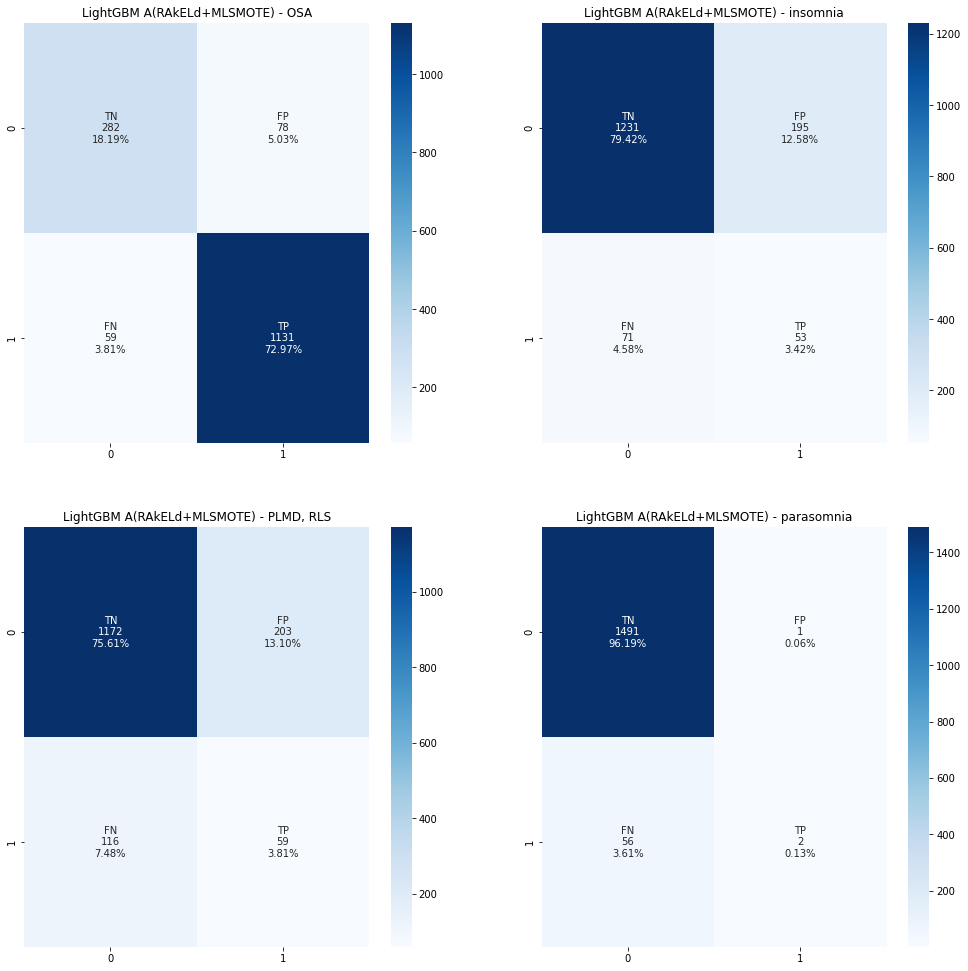

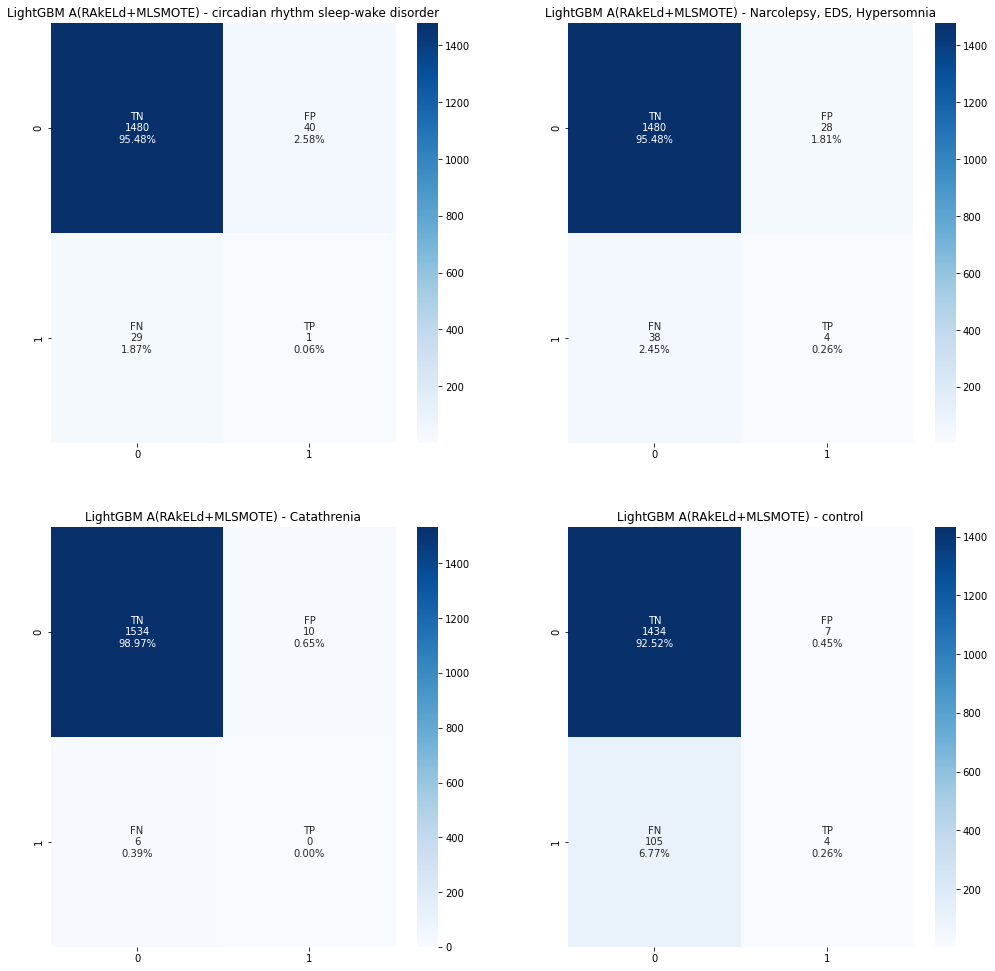

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [29]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [30]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+14, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+14, cell.col, score)

In [31]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, True], 'labelset_size': 9} 0.821408890722868


total accuracy: 0.7651612903225806
OSA accuracy: 0.9148387096774193
insomnia accuracy: 0.9212903225806451
PLMD, RLS accuracy: 0.9090322580645162
parasomnia accuracy: 0.9625806451612903
circadian rhythm sleep-wake disorder accuracy: 0.98
Narcolepsy, EDS, Hypersomnia accuracy: 0.9722580645161291
Catathrenia accuracy: 0.9987096774193548
control accuracy: 0.9451612903225807


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.93      0.96      0.95      1190
                            insomnia       0.51      0.44      0.47       124
                           PLMD, RLS       0.66      0.41      0.50       175
                          parasomnia       0.00      0.00      0.00        58
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        30
        Narcolepsy, EDS, Hypersomnia       0.40      0.05      0.09        42
                         Catathrenia       1.00      0.67      0.80         6
                             control       0.59      0.72      0.65       109

                           micro avg       0.85      0.78      0.82      1734
                           macro avg       0.51      0.41      0.43      1734
                        weighted avg       0.79      0.78      0.78      1734
                         samples avg       0.86      0.82     

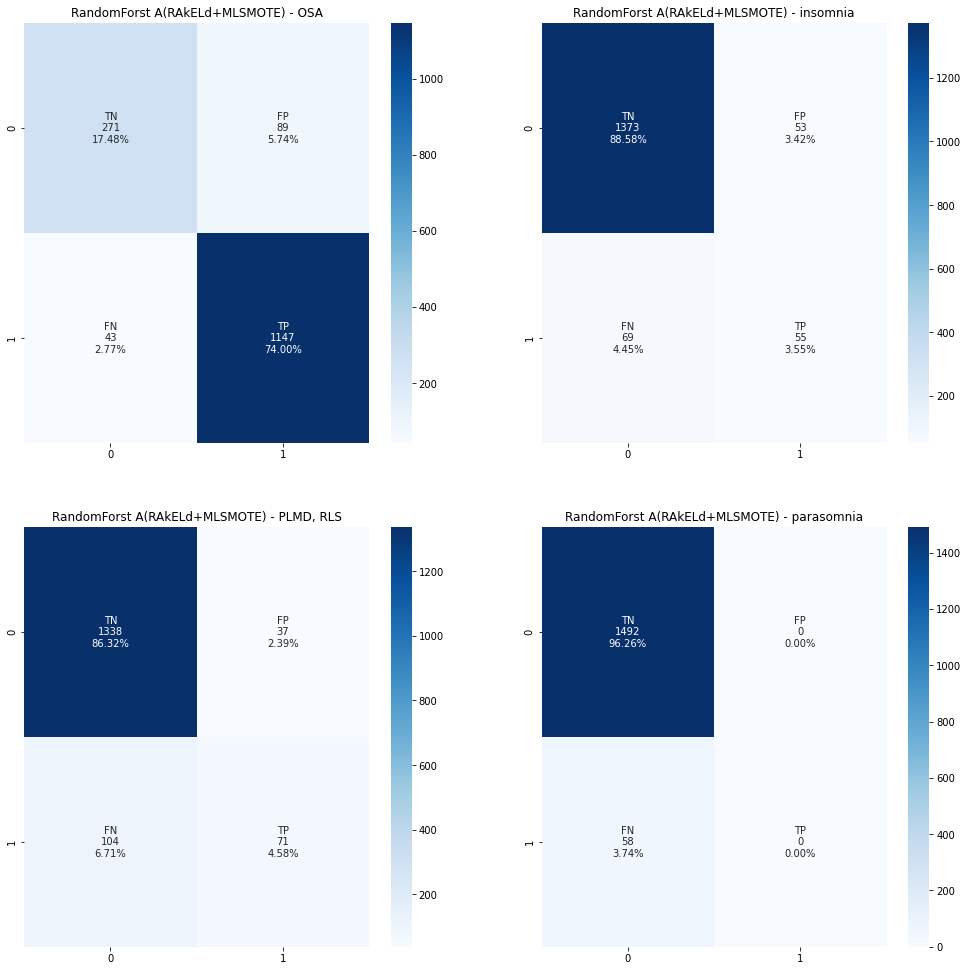

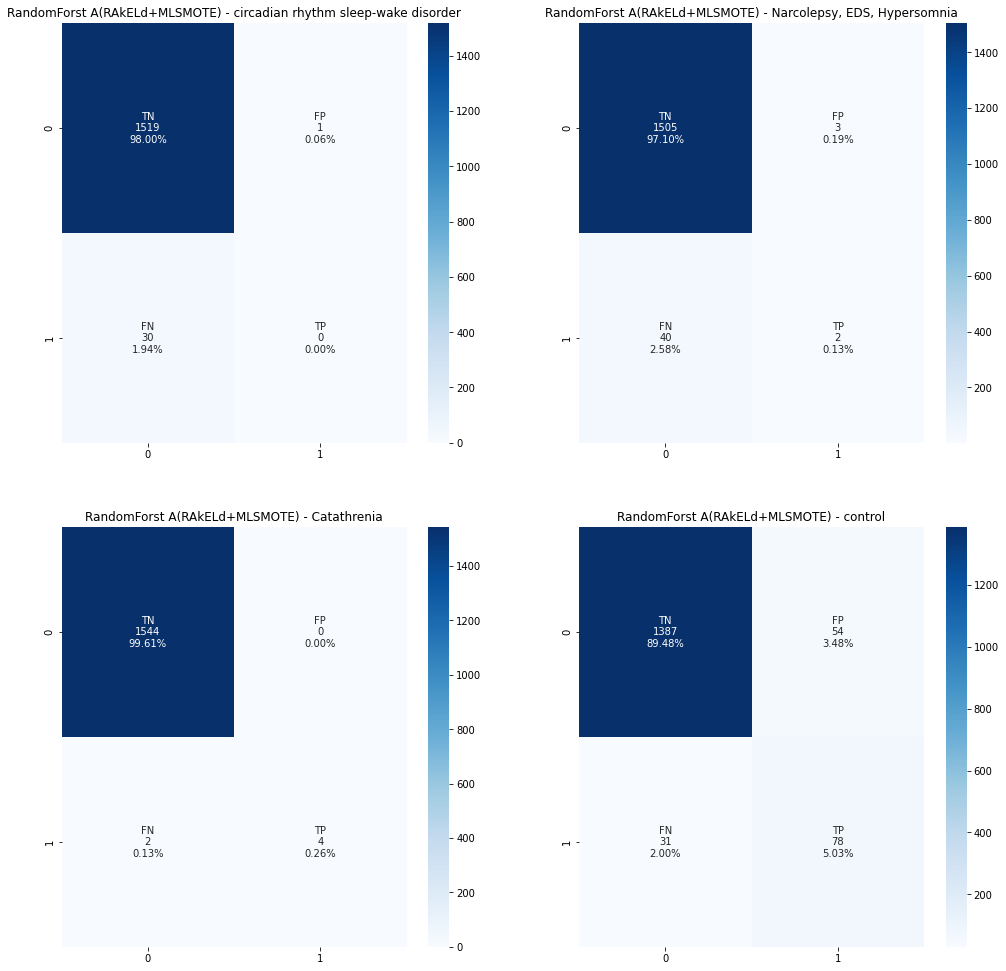

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [33]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [34]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+2, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+2, cell.col, score)

## MLeNN

In [35]:
def caculate_IRLbl(Y):
    # imbalance ratio per label
    posNumsPerLabel = np.sum(Y, axis=0)
    maxPosNums = np.max(posNumsPerLabel)
    return maxPosNums / posNumsPerLabel


def caculate_meanIR(Y):
    # average imbalance ratio
    IRLbl = caculate_IRLbl(Y)
    return np.mean(IRLbl)


def get_minBag(Y):
    n, m = Y.shape
    IRLbl = caculate_IRLbl(Y)
    meanIR = caculate_meanIR(Y)
    return [i for i in range(m) if IRLbl[i] > meanIR]


def get_minMajInstInd(Y, minBag):
    n, m = Y.shape
    minInstInd = []
    majInstInd = []
    for i in range(n):
        if (Y[i, minBag]==1).any():
            minInstInd.append(i)
        else:
            majInstInd.append(i)
    return minInstInd, majInstInd


def adjust_hamming_distance(y1, y2):
    flag1 = np.sum(y1)
    flag2 = np.sum(y2)
    if flag1 and flag2:
        ele = np.sum((y1 + y2)==1)
        den = flag1 + flag2
        return ele / den
    else:
        return 1


def NN_index(X, k=5):
    # n_neighbors including the sample itself, 
    # so we take the number of n_neighbors as k+1 (as the following shows),
    # then delete itself from the neighbors.
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', 
                           algorithm='auto').fit(X)
    euclidean, index = nn.kneighbors(X)
    return index[:,1:]


def MLeNN(X, Y, NN=3, HT=0.75):
    # MLeNN (MultiLabel edited Nearest Neighbor)
    nnIndex = NN_index(X, NN)
    minBag = get_minBag(Y)
    minInstInd, majInstInd = get_minMajInstInd(Y, minBag)
    markForRemoving = []
    for sampleIndex in majInstInd:
        numDifferences = 0
        sampleNNIndexs = nnIndex[sampleIndex,:]
        for sampleNNIndex in sampleNNIndexs:
            adjustedHammingDist = adjust_hamming_distance(Y[sampleIndex,:],
                                                          Y[sampleNNIndex,:])
            if adjustedHammingDist > HT:
                numDifferences = numDifferences + 1
        if numDifferences >= (NN/2):
#             print("Remove:", sampleIndex)
            markForRemoving.append(sampleIndex)
    
    X_new = np.delete(X, markForRemoving, axis=0)
    Y_new = np.delete(Y, markForRemoving, axis=0)
    return X_new, Y_new

In [36]:
X_new_a, Y_new_a = MLeNN(X_a, Y_a, NN=3, HT=0.75)
print(X_new_a.shape, Y_new_a.shape)

(4166, 77) (4166, 8)


In [37]:
mlenn_data_a = pd.DataFrame(X_new_a, columns=data_a.columns[:2].tolist()+data_a.columns[10:].tolist())
mlenn_label_a = pd.DataFrame(Y_new_a, columns=data_a.columns[2:10].tolist())

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(mlenn_data_a, mlenn_label_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [38]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, False], 'labelset_size': 7} 0.930440662766199


total accuracy: 0.8528
OSA accuracy: 0.9736
insomnia accuracy: 0.9728
PLMD, RLS accuracy: 0.9272
parasomnia accuracy: 0.9736
circadian rhythm sleep-wake disorder accuracy: 0.9928
Narcolepsy, EDS, Hypersomnia accuracy: 0.9896
Catathrenia accuracy: 0.9976
control accuracy: 0.9824


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.98      0.99      0.99      1109
                            insomnia       0.66      0.57      0.61        47
                           PLMD, RLS       0.67      0.42      0.52       116
                          parasomnia       0.67      0.06      0.11        34
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         8
        Narcolepsy, EDS, Hypersomnia       0.50      0.08      0.13        13
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.84      0.82      0.83        66

                           micro avg       0.94      0.88      0.91      1396
                           macro avg       0.54      0.37      0.40      1396
                        weighted avg       0.92      0.88      0.89      1396
                         samples avg       0.95      0.92     

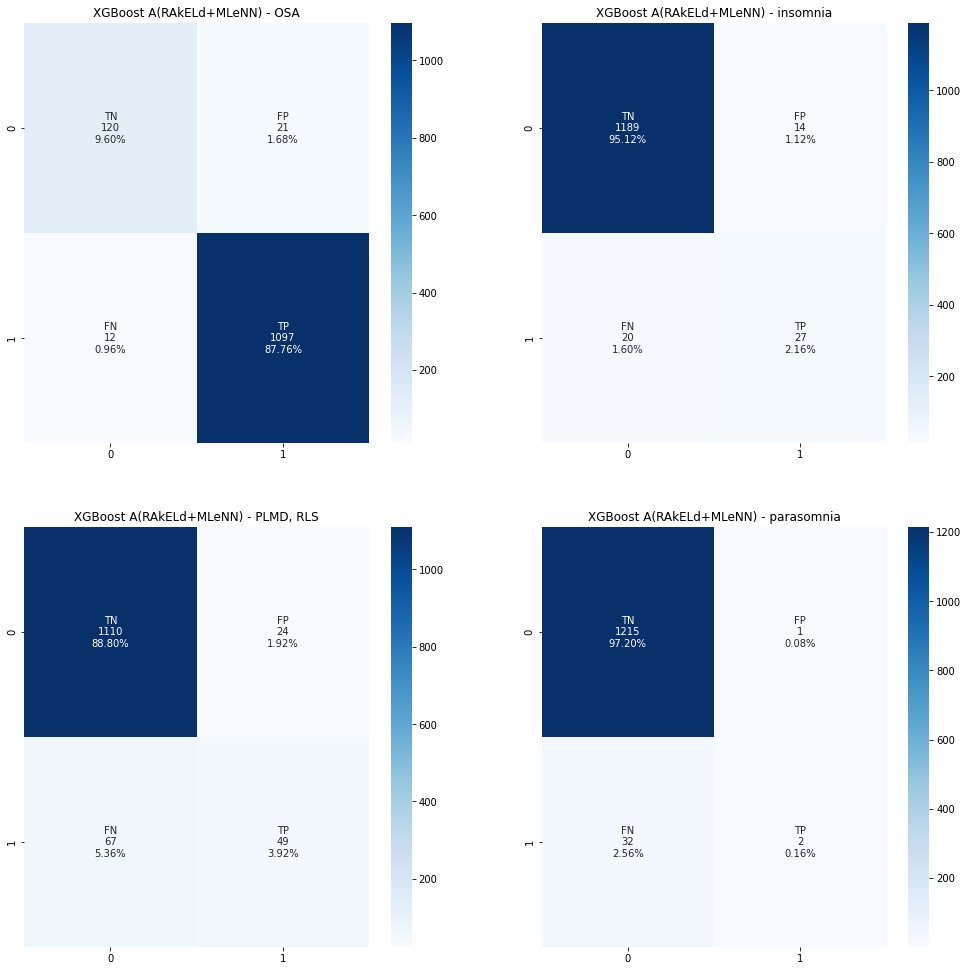

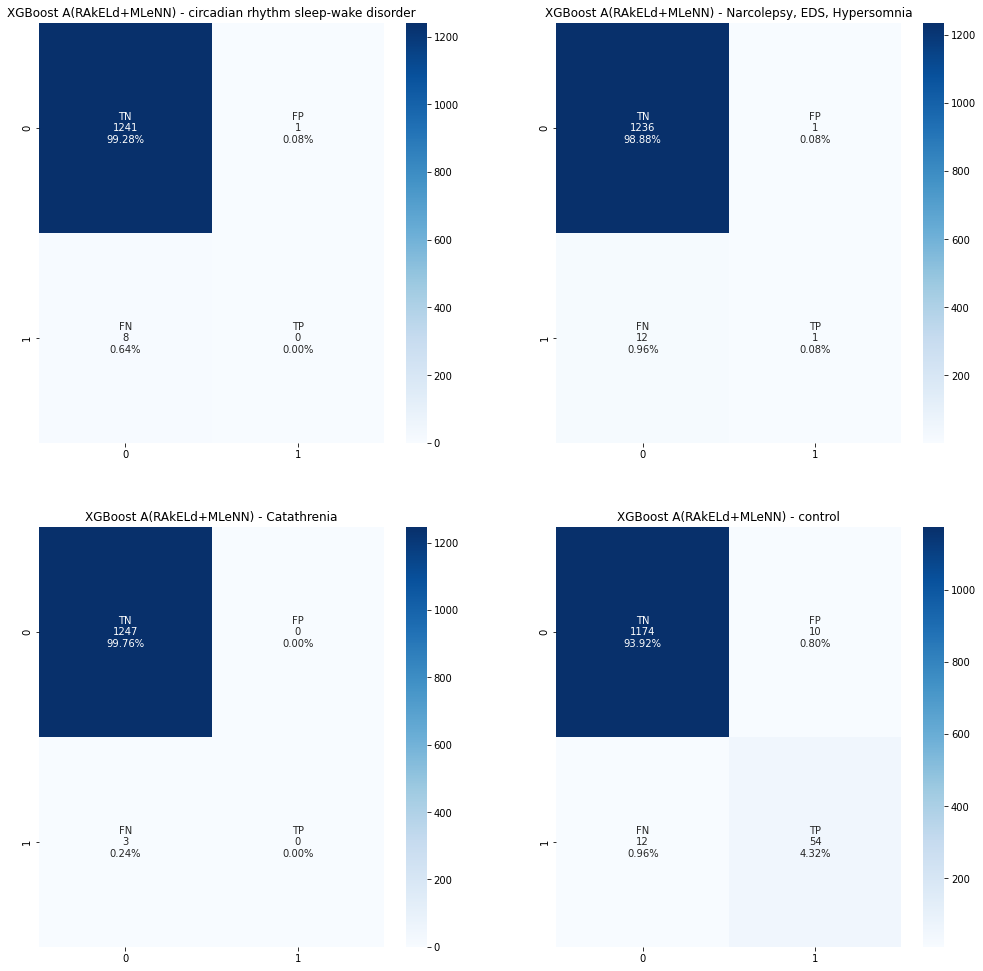

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [40]:
time.sleep(45)

gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [41]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+9, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+9, cell.col, score)

In [42]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, False], 'labelset_size': 10} 0.9299945565763608


total accuracy: 0.86
OSA accuracy: 0.9744
insomnia accuracy: 0.9712
PLMD, RLS accuracy: 0.9304
parasomnia accuracy: 0.9728
circadian rhythm sleep-wake disorder accuracy: 0.9936
Narcolepsy, EDS, Hypersomnia accuracy: 0.9896
Catathrenia accuracy: 0.9976
control accuracy: 0.9848


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.98      0.99      0.99      1109
                            insomnia       0.64      0.53      0.58        47
                           PLMD, RLS       0.72      0.41      0.52       116
                          parasomnia       0.00      0.00      0.00        34
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         8
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        13
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.84      0.88      0.86        66

                           micro avg       0.95      0.88      0.91      1396
                           macro avg       0.40      0.35      0.37      1396
                        weighted avg       0.90      0.88      0.89      1396
                         samples avg       0.96      0.92     

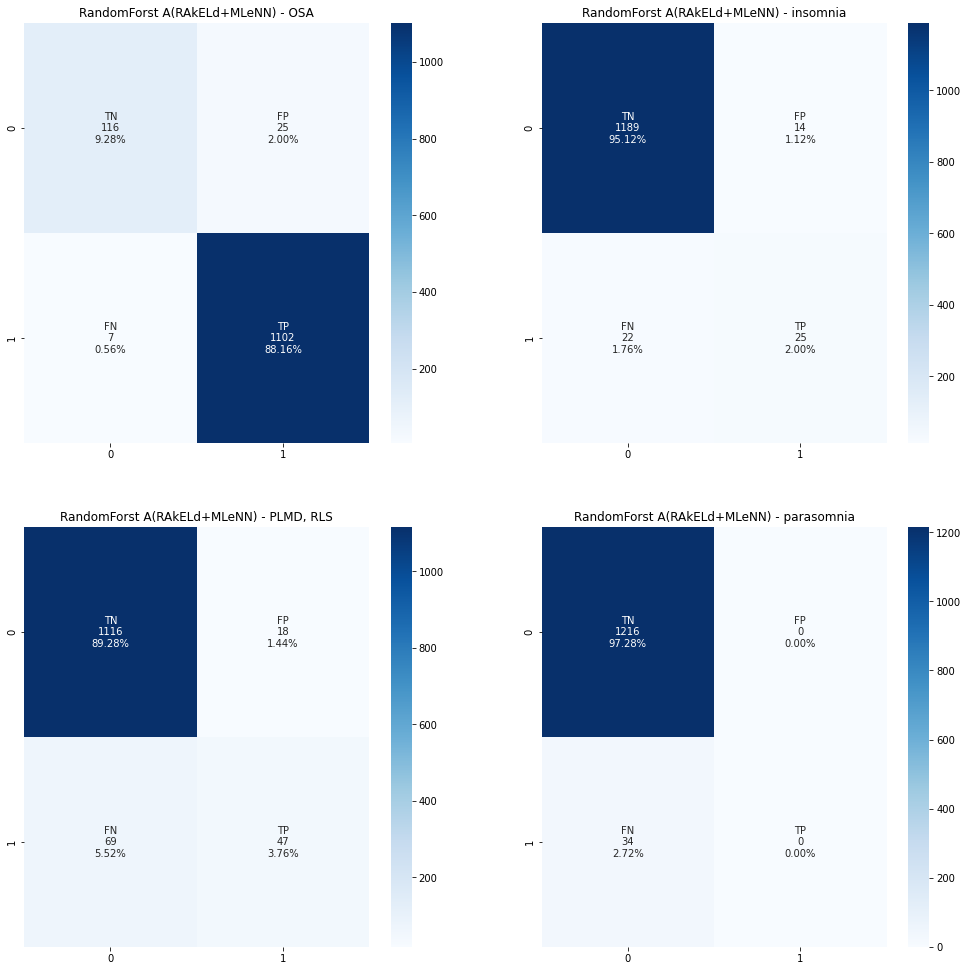

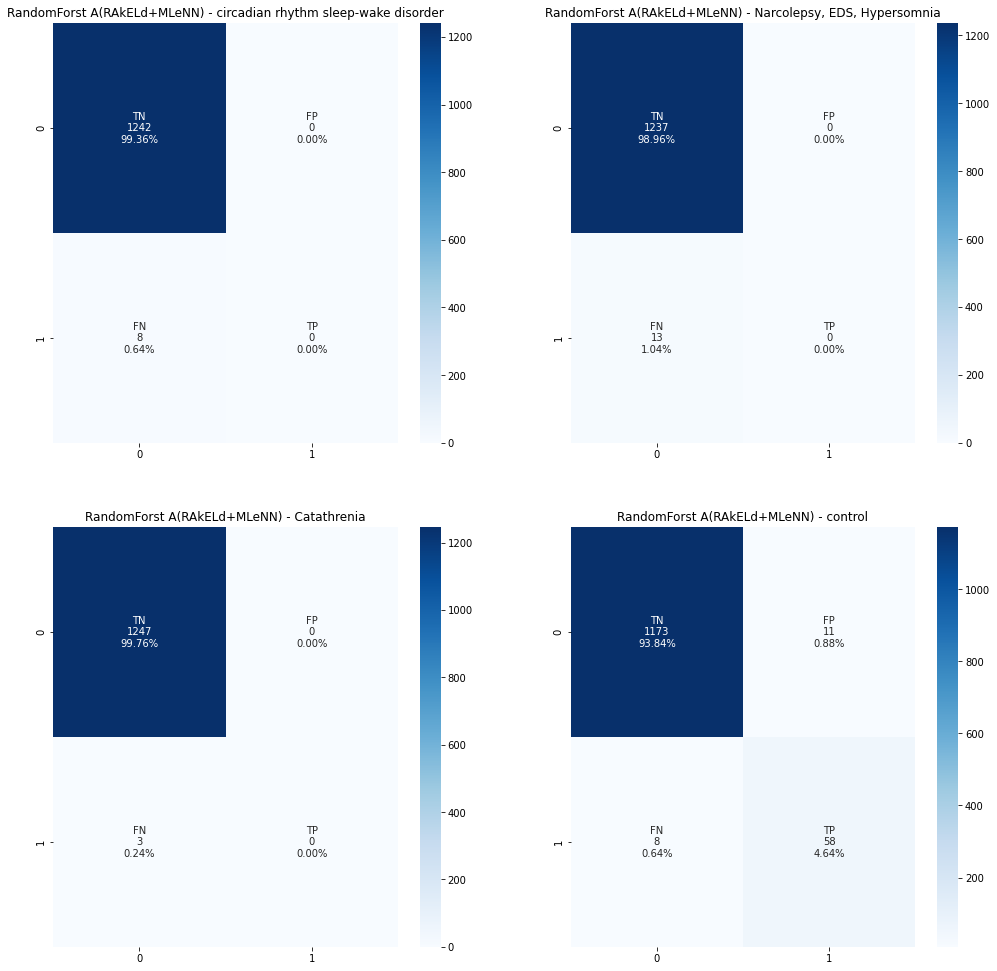

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [44]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [45]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+3, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+3, cell.col, score)

In [46]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, False], 'labelset_size': 12} 0.932638082818362


total accuracy: 0.6208
OSA accuracy: 0.7224
insomnia accuracy: 0.7656
PLMD, RLS accuracy: 0.8936
parasomnia accuracy: 0.9584
circadian rhythm sleep-wake disorder accuracy: 0.9552
Narcolepsy, EDS, Hypersomnia accuracy: 0.948
Catathrenia accuracy: 0.9864
control accuracy: 0.9496
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.73      0.82      1109
                            insomnia       0.05      0.30      0.09        47
                           PLMD, RLS       0.16      0.03      0.06       116
                          parasomnia       0.05      0.03      0.04        34
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         8
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        13
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.51      0.82      0.63        66

                  

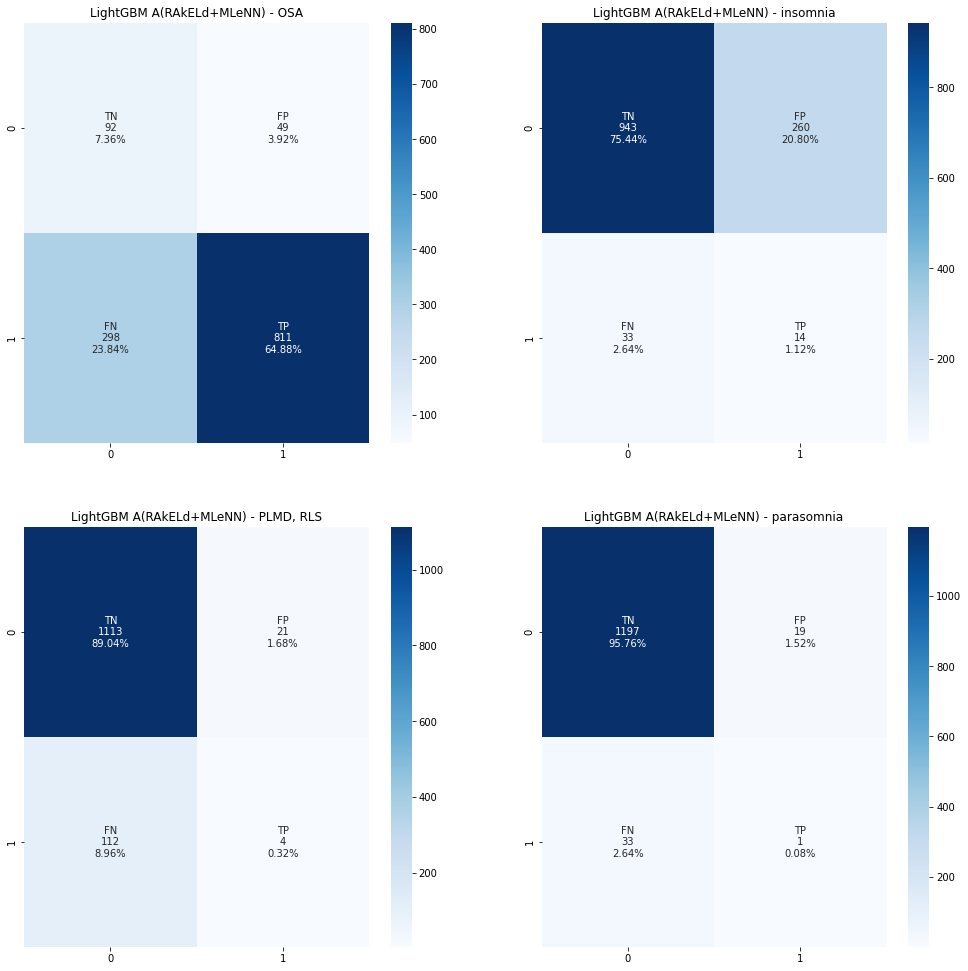

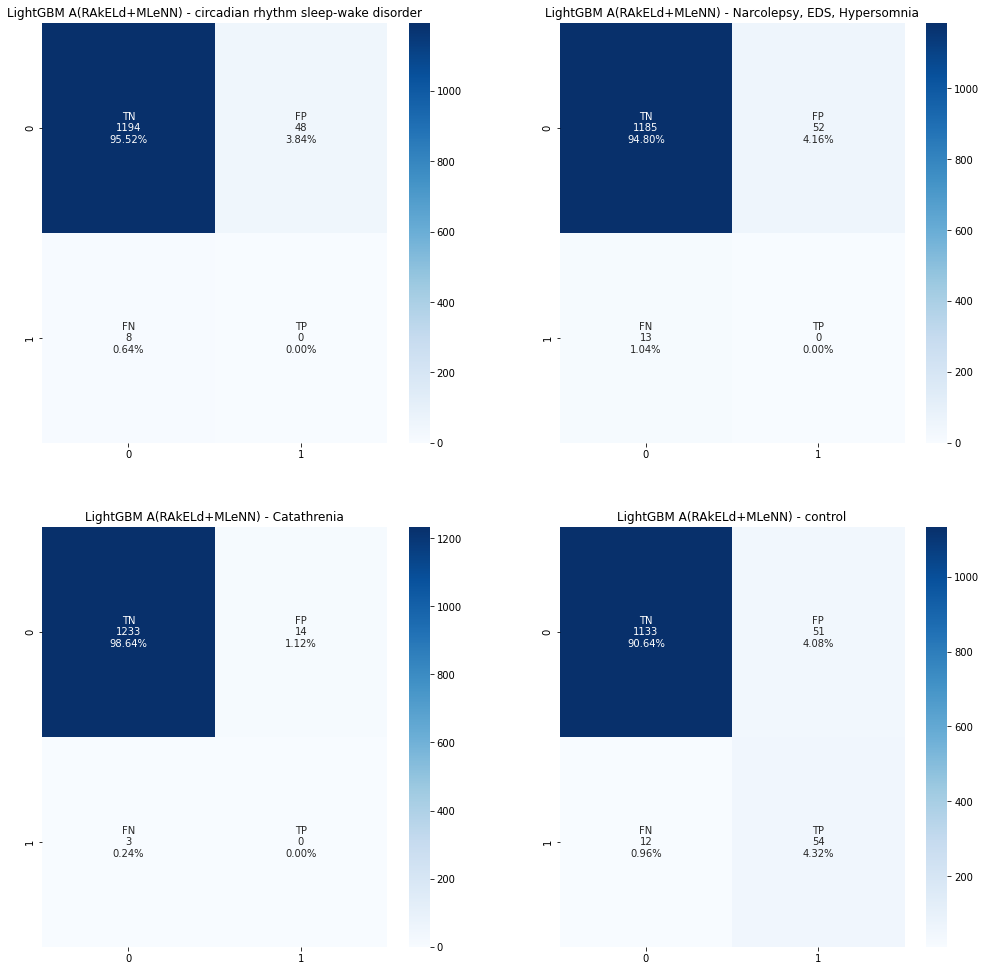

In [47]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [48]:
gc = gspread.service_account(filename='../input/sleep-research/credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [49]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+15, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+15, cell.col, score)